In [1]:

import pandas as pd

# Load the CSV file into a DataFrame to be used in the clustering process
df = pd.read_csv('Data/Partitioned_Abstracts.csv', sep=',', header=0, encoding='utf-8')

#verify that the DataFrame is loaded correctly
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 1228 non-null   object
 1   Year                  1228 non-null   int64 
 2   Authors               1228 non-null   object
 3   Label                 1228 non-null   object
 4   Partitioned Abstract  1228 non-null   object
 5   Target                1228 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 57.7+ KB


In [3]:
from sentence_transformers import SentenceTransformer

#Create the combined text by concatenating the "Title" and "Partitioned Abstract" columns
combined_texts = df["Title"].astype(str) + "\n\n" + df["Partitioned Abstract"].astype(str)
# Convert the "Target" column to integer type for classification purposes
targets = df["Target"].astype(int)

# Load the SentenceTransformer model for generating embeddings
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Define the task type for the model
task = "clustering"

# Encode the combined texts using the SentenceTransformer model
embeddings = model.encode(
    combined_texts.tolist(),
    show_progress_bar=True,
    device="cuda",
    convert_to_tensor=True,
)
embeddings.shape


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

torch.Size([1228, 1024])

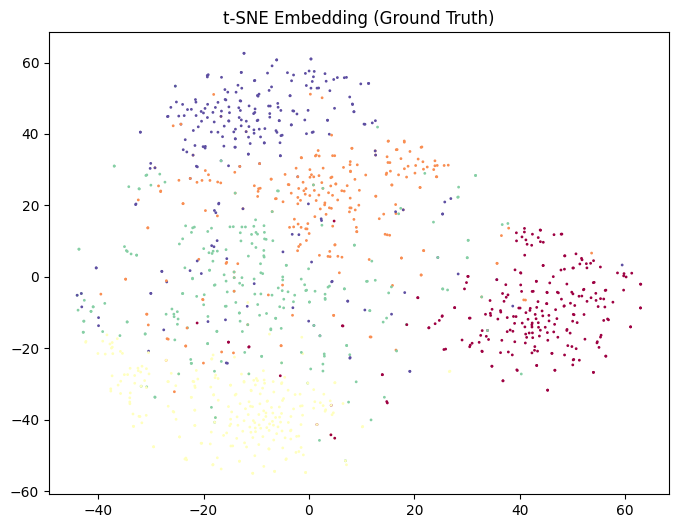

In [4]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: t-SNE on embeddings (for visualization)
embeddings_np = embeddings.cpu().to(torch.float32).numpy()
tsne_embedding = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(
    embeddings_np
)

# Step 2: Visualize t-SNE embedding colored by ground truth labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=targets, s=1, cmap='Spectral')
plt.title("t-SNE Embedding (Ground Truth)")
plt.show()


In [5]:
from sklearn.cluster import KMeans
import numpy as np

# Step 3: KMeans clustering on original embeddings
kmeans = KMeans(n_clusters=len(np.unique(targets)), random_state=42, n_init="auto")
labels_kmeans = kmeans.fit_predict(embeddings_np)


In [6]:
kmeans_tsne = KMeans(n_clusters=len(np.unique(targets)), random_state=42, n_init="auto")
labels_kmeans_tsne = kmeans_tsne.fit_predict(tsne_embedding)


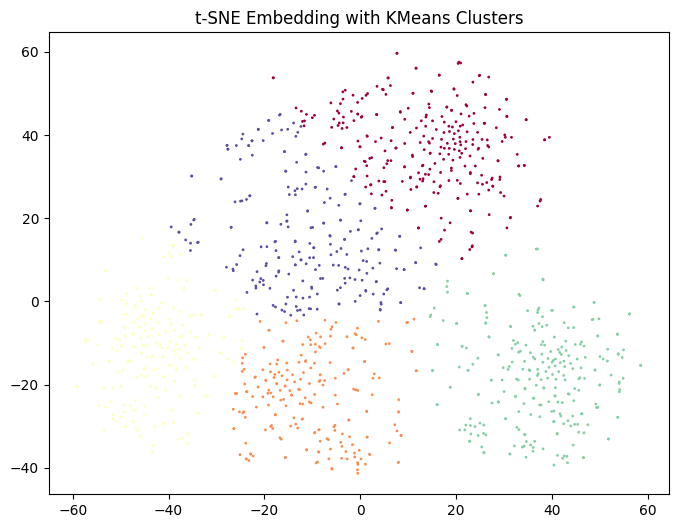

In [10]:
# Visualize KMeans clusters on t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=labels_kmeans_tsne, s=1, cmap='Spectral')
plt.title("t-SNE Embedding with KMeans Clusters")
plt.show()


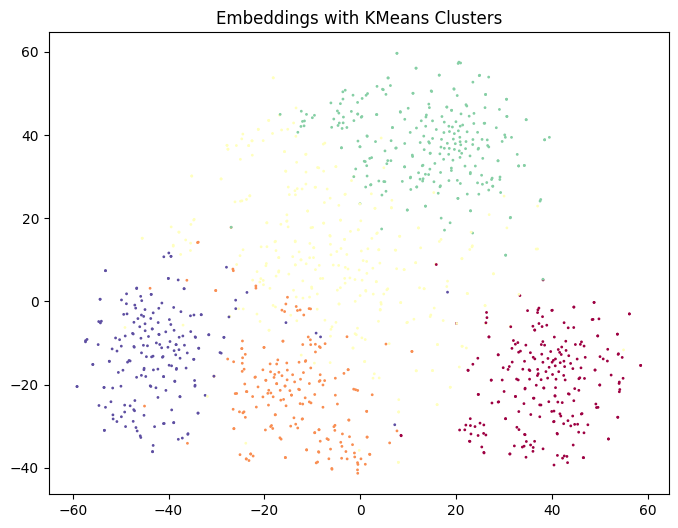

In [11]:
# Visualize KMeans clusters on t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=labels_kmeans, s=1, cmap='Spectral')
plt.title("Embeddings with KMeans Clusters")
plt.show()

In [7]:
kmeans_tsne_3d = KMeans(n_clusters=len(np.unique(targets)), random_state=42, n_init="auto")
tsne_embedding_3d = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(
    embeddings.cpu().to(torch.float32).numpy()
)

labels_kmeans_tsne3d = kmeans_tsne.fit_predict(tsne_embedding_3d)

In [13]:
import plotly.express as px
import pandas as pd


df_plot = pd.DataFrame(tsne_embedding_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_kmeans # or labels_kmeans
df_plot["Title"] = df["Title"]
df_plot["Partitioned Abstract"] = df["Partitioned Abstract"].values

cluster_texts = {}
for label in np.unique(labels_kmeans):
    cluster_texts[label] = df_plot[df_plot["Cluster"] == label]["Partitioned Abstract"].tolist()  # or use combined_texts


from bertopic import BERTopic

topic_labels = {}

for label, texts in cluster_texts.items():
    try:
        topic_model = BERTopic(
            # Optionally pass a custom vectorizer or representation model
            calculate_probabilities=False,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        top_topic_id = list(topic_model.get_topics().keys())[0]
        top_words = topic_model.get_topic(top_topic_id)
        # Get top 3 words as label
        label_text = ", ".join([word for word, _ in top_words[:3]])
        topic_labels[label] = label_text
    except Exception as e:
        print(f"[WARN] Cluster {label} failed: {e}")
        topic_labels[label] = f"Cluster {label}"


df_plot["ClusterLabel"] = df_plot["Cluster"].apply(
    lambda x: "Noise" if x == -1 else topic_labels.get(x, f"Cluster {x}")
)


fig = px.scatter_3d(
    df_plot,
    x="x", y="y", z="z",
    color="ClusterLabel",
    hover_name="Title",
    title="KMeans Clusters in 3D",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
    bgcolor="lightgrey"
))
fig.write_html("kmeans_plotly.html")


In [17]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame(tsne_embedding_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_kmeans_tsne3d  # or labels_kmeans
df_plot["Title"] = df["Title"]
df_plot["Partitioned Abstract"] = df["Partitioned Abstract"].values

cluster_texts = {}
for label in np.unique(labels_kmeans_tsne):
    cluster_texts[label] = df_plot[df_plot["Cluster"] == label]["Partitioned Abstract"].tolist()  # or use combined_texts


from bertopic import BERTopic

topic_labels = {}

for label, texts in cluster_texts.items():
    try:
        topic_model = BERTopic(
            # Optionally pass a custom vectorizer or representation model
            calculate_probabilities=False,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        top_topic_id = list(topic_model.get_topics().keys())[0]
        top_words = topic_model.get_topic(top_topic_id)
        # Get top 3 words as label
        label_text = ", ".join([word for word, _ in top_words[:3]])
        topic_labels[label] = label_text
    except Exception as e:
        print(f"[WARN] Cluster {label} failed: {e}")
        topic_labels[label] = f"Cluster {label}"


df_plot["ClusterLabel"] = df_plot["Cluster"].apply(
    lambda x: "Noise" if x == -1 else topic_labels.get(x, f"Cluster {x}")
)


fig = px.scatter_3d(
    df_plot,
    x="x", y="y", z="z",
    color="ClusterLabel",
    hover_name="Title",
    title="KMeans Clusters in t-SNE 3D",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
    bgcolor="lightgrey"
))
fig.write_html("tsne_kmeans_plotly.html")

In [18]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_score


# Function to align clusters to ground truth
def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

# Remove noise if necessary (not for KMeans, but keep the structure)
mask = np.ones_like(labels_kmeans, dtype=bool)
true_labels = df["Target"].values
cluster_labels = labels_kmeans[mask]
gt_labels = true_labels[mask]

aligned_preds = align_clusters(gt_labels, cluster_labels)
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (KMeans vs. Target): {kappa:.4f}")

score_kmeans = silhouette_score(embeddings_np, labels_kmeans)
print(f"KMeans Silhouette Score: {score_kmeans:.4f}")

Cohen’s Kappa (KMeans vs. Target): 0.7650
KMeans Silhouette Score: 0.0788


In [20]:
# Remove noise if necessary (not for KMeans, but keep the structure)
mask = np.ones_like(labels_kmeans_tsne, dtype=bool)
true_labels = df["Target"].values
cluster_labels = labels_kmeans_tsne[mask]
gt_labels = true_labels[mask]

aligned_preds = align_clusters(gt_labels, cluster_labels)
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (KMeans with t-sne 2D embeddings vs. Target): {kappa:.4f}")

score_kmeans = silhouette_score(embeddings_np, labels_kmeans_tsne)
print(f"KMeans (TSNE embeddings) Silhouette Score: {score_kmeans:.4f}")

Cohen’s Kappa (KMeans with t-sne 2D embeddings vs. Target): 0.7466
KMeans (TSNE embeddings) Silhouette Score: 0.0713


In [21]:
# Remove noise if necessary (not for KMeans, but keep the structure)
mask = np.ones_like(labels_kmeans_tsne3d, dtype=bool)
true_labels = df["Target"].values
cluster_labels = labels_kmeans_tsne3d[mask]
gt_labels = true_labels[mask]

aligned_preds = align_clusters(gt_labels, cluster_labels)
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (KMeans with t-sne 3D embeddings vs. Target): {kappa:.4f}")
score_kmeans = silhouette_score(embeddings_np, labels_kmeans_tsne3d)
print(f"KMeans (TSNE 3D embeddings) Silhouette Score: {score_kmeans:.4f}")

Cohen’s Kappa (KMeans with t-sne 3D embeddings vs. Target): 0.6793
KMeans (TSNE 3D embeddings) Silhouette Score: 0.0620


In [11]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Load your data
df = pd.read_csv('Data/Partitioned_Abstracts.csv', sep=',', header=0, encoding='utf-8')

# Add GMM cluster labels to dataframe
df['Cluster_kmeans'] = labels_kmeans
df['Cluster_kmeans_tsne'] = labels_kmeans_tsne
df['Cluster_kmeans_tsne3d'] = labels_kmeans_tsne3d

# Tokenize the partitioned abstracts (simple split, or use your cleaning/tokenizer if you have one)
def simple_tokenize(text):
    return str(text).lower().split()

df['tokens'] = df['Partitioned Abstract'].apply(simple_tokenize)

# --- For raw GMM clusters ---
cluster_docs = df.groupby('Cluster_kmeans')['tokens'].apply(list)
cluster_word_lists = [sum(docs, []) for docs in cluster_docs]

# Build Gensim dictionary and texts
dictionary = Dictionary(df['tokens'])
texts = df['tokens'].tolist()

# Compute coherence
coherence_model_kmeans = CoherenceModel(
    topics=[list(set(words))[:10] for words in cluster_word_lists],  # Top 10 unique words per cluster
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score_kmeans = coherence_model_kmeans.get_coherence()
print(f"kmeans Coherence Score (raw embeddings): {coherence_score_kmeans:.4f}")

# --- For kmeans with TSNE 2D clusters ---
cluster_docs_tsne = df.groupby('Cluster_kmeans_tsne')['tokens'].apply(list)
cluster_word_lists_tsne = [sum(docs, []) for docs in cluster_docs_tsne]

coherence_model_kmeans_tsne = CoherenceModel(
    topics=[list(set(words))[:10] for words in cluster_word_lists_tsne],
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score_kmeans_tsne = coherence_model_kmeans_tsne.get_coherence()
print(f"K-means Coherence Score (TSNE 2D embeddings): {coherence_score_kmeans_tsne:.4f}")

# --- For kmeans with TSNE 3D clusters ---
cluster_docs_tsne3d = df.groupby('Cluster_kmeans_tsne3d')['tokens'].apply(list)
cluster_word_lists_tsne3d = [sum(docs, []) for docs in cluster_docs_tsne3d]

coherence_model_kmeans_tsne3d = CoherenceModel(
    topics=[list(set(words))[:10] for words in cluster_word_lists_tsne3d],
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score_kmeans_tsne3d = coherence_model_kmeans_tsne3d.get_coherence()
print(f"K-means Coherence Score (TSNE 3D embeddings): {coherence_score_kmeans_tsne3d:.4f}")


kmeans Coherence Score (raw embeddings): 0.4787
K-means Coherence Score (TSNE 2D embeddings): 0.5040
K-means Coherence Score (TSNE 3D embeddings): 0.4775
